# Terror5

# Step 1. Load data
Load csv file in a dataframe, check encoding and low_memory=False because some columns are mix types.
Columns (4,61,62,66,116,117,123) have mixed types.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# %pdb

import pandas as pd

gtd = pd.read_csv('gtd_utf.csv', encoding='latin1', low_memory=False)
gtd.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=137)

**Check groups bias**

Which group is responsible for the attacks?

In [25]:
from collections import Counter

# Terrorist group name is the target
target = gtd['gname']

gcount = Counter(target)
print('Number of groups = {}'.format(len(gcount)))
g1 = gcount.most_common(1)[0]
print('Be careful with bias, {} = {:.4f}%'.format(g1[0], 100 * g1[1] / target.size))
gcount.most_common(5)

Number of groups = 3290
Be careful with bias, Unknown = 45.8768%


[('Unknown', 71922),
 ('Taliban', 5502),
 ('Shining Path (SL)', 4548),
 ('Farabundo Marti National Liberation Front (FMLN)', 3351),
 ('Islamic State of Iraq and the Levant (ISIL)', 2833)]

# Step 2. Preprocessing

In [26]:
from collections import Counter

threshold = 10
group_count = Counter(gtd['gname'])
groups = [group for group, counter in group_count.items() if counter >= threshold]
len(groups)

527

In [27]:
gtd_clean = gtd[gtd['gname'].isin(groups)]
len(gtd_clean)

150816

### Step 2.1 Remove unknowns

In [28]:
# Remove Unknowns

region2 = gtd_clean[(gtd_clean['region']==2) & (gtd_clean['gname']!='Unknown')]
total_region2 = len(region2)

### Step 2.2 Remove a particular biased group

In [29]:
# Remove a particular group that skews predictions

#region2 = region2[(region2['gname']!='Farabundo Marti National Liberation Front (FMLN)')]
#len(region2)

# Step 3. Naive Bayes Classifier

### Step 3.1 Splitting into Training and Testing sets

In [49]:
from sklearn.model_selection import train_test_split

features_used = ['iyear', 'country']

data_target = region2['gname']
data_features = region2[features_used]

X_train, X_test, Y_train, Y_test = train_test_split(data_features, data_target, test_size=0.30)

train = pd.concat([Y_train, X_train], axis=1)
test = pd.concat([Y_test, X_test], axis=1)

year_counts = X_train['iyear'].value_counts()
total_years = len(year_counts)
year_probabilities = year_counts / total_years

country_counts = X_train['country'].value_counts()
total_country = len(country_counts)
country_probabilities = country_counts / total_country

train_groups = pd.unique(Y_train)
train_years = pd.unique(X_train['iyear'])
train_countries = pd.unique(X_train['country'])

train_groups_len = len(train_groups)
train_years_len = len(train_years)
train_countries_len = len(train_countries)

train_groups_year_likelihoods = [(x, y, 0) for x in train_groups for y in train_years]
train_groups_country_likelihoods = [(x, y, 0) for x in train_groups for y in train_countries]

train_groups_year_likelihoods = pd.DataFrame(train_groups_year_likelihoods)
train_groups_country_likelihoods = pd.DataFrame(train_groups_country_likelihoods)

train_groups_year_likelihoods.columns = ['gname', 'year', 'likelihood']
train_groups_country_likelihoods.columns = ['gname', 'country', 'likelihood']

### Step 3.2 Do the magic

In [50]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb = MultinomialNB()
y_pred = gnb.fit(X_train, Y_train).predict(X_test)

good_predictions = (Y_test == y_pred).sum()
total_predictions = len(Y_test)

print("Good predictions " + str(good_predictions) + " out of " + str(total_predictions))
print
print("Accuracy: " + str((good_predictions/total_predictions)*100) + "%")

Good predictions 1325 out of 1908
Accuracy: 69.4444444444%


In [37]:
actual_vs_predicted = [(x, y) for x in Y_test for y in y_pred]

print(actual_vs_predicted)

In [61]:
from sklearn.metrics import confusion_matrix
conf_arr = confusion_matrix(Y_test, y_pred)

print(len(pd.unique(Y_test)))
print(conf_arr.shape)

51
(51, 51)


"\nfor x in xrange(width):\n    for y in xrange(height):\n        ax.annotate(str(conf_arr[x][y]), xy=(y, x), \n                    horizontalalignment='center',\n                    verticalalignment='center')\n\ncb = fig.colorbar(res)\nalphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'\nplt.xticks(range(width), alphabet[:width])\nplt.yticks(range(height), alphabet[:height])\nplt.savefig('confusion_matrix.png', format='png')\n"

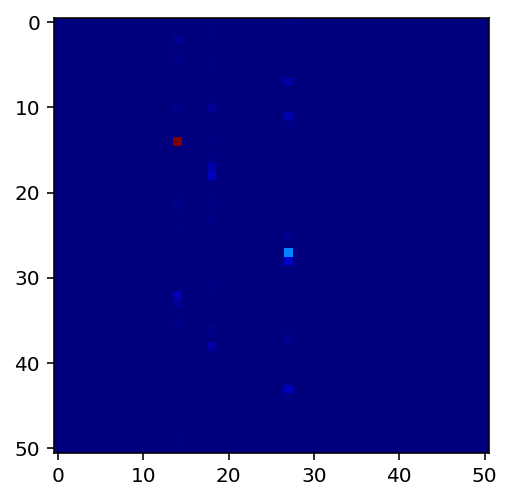

In [62]:
import numpy as np
import matplotlib.pyplot as plt

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(conf_arr), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape
'''
for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.savefig('confusion_matrix.png', format='png')
'''